In [40]:
from writers import foyer_xml_writer
from writers.foyer_xml_writer import parmed_to_foyer_xml, mbuild_to_foyer_xml


import ele
import espaloma as esp
import forcefield_utilities as ffutils
import foyer
import gmso
import mbuild as mb
from mbuild.lib.recipes import Polymer
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import numpy as np
from openff.toolkit.topology import Molecule
from openff.toolkit.topology import Topology
import torch
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import hoomd
import gsd.hoomd
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("espaloma_model.pt"):
    os.system("wget http://data.wangyq.net/espaloma_model.pt")

In [9]:
from rdkit import Chem

In [20]:
Chem.MolToSmiles(Chem.MolFromSmiles('[CH]1C2=NSN=C2C=N[CH]1'))

'[CH]1[CH]c2nsnc2C=N1'

In [13]:
mb.load("[CH]1C2=NSN=C2C=N[CH]1",smiles=True).visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [57]:
#cant get the sdf file or mol file to work with N-S-N bonds, it works from smiles string though...
#either need to get smiles string directly from mol2 file or figure out how to get the 
#smiles string from the smi file into a usable format. 
#it worked to run openbabel and get the smile string from the smi file and then just 
#delete the brackets around the N's.

molecule = Molecule.from_file("pt.sdf",file_format = "sdf")

#molecule = Molecule.from_smiles("[CH]1C2=NSN=C2C=N[CH]1")

#[CH]1[C]2[N]S[N][C]2[CH][N][CH]1

molecule_graph = esp.Graph(molecule)
#either generate smiles string from the built fragments or get our fragments into a Molecule supported file format

espaloma_model = torch.load("espaloma_model.pt")
espaloma_model(molecule_graph.heterograph)
openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph)

# Store the results for each in something more accessible
pair_forces = openmm_system.getForces()[1]
angle_forces = openmm_system.getForces()[3]
bond_forces = openmm_system.getForces()[2]
torsion_forces = openmm_system.getForces()[0]

UnassignedProperTorsionParameterException: ProperTorsionHandler was not able to find parameters for the following valence terms:

- Topology indices (3, 4, 5, 6): names and elements ( S), ( N), ( C), ( C), 
- Topology indices (5, 6, 7, 8): names and elements ( C), ( C), ( N), ( C), 
- Topology indices (3, 2, 1, 5): names and elements ( S), ( N), ( C), ( C), 
- Topology indices (1, 5, 4, 3): names and elements ( C), ( C), ( N), ( S), 
- Topology indices (0, 8, 7, 6): names and elements ( C), ( C), ( N), ( C), 
- Topology indices (6, 7, 8, 11): names and elements ( C), ( N), ( C), ( H), 
- Topology indices (8, 7, 6, 10): names and elements ( C), ( N), ( C), ( H), 
- Topology indices (0, 1, 2, 3): names and elements ( C), ( C), ( N), ( S), 


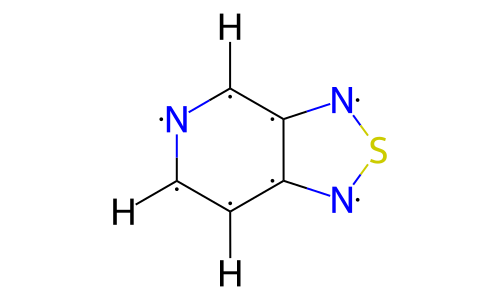

In [58]:
molecule.visualize()

In [ ]:
#start problem with 
#create class for molecule walker function that keeps track of all the variables that we need to know for 
#each atom position
#start at random position and evaluate if the octet is satified, if so, step to next atom. if not add bond and 
#step to next, evaluate that octet and if it is broken step back and undo the bond created. create new bond 
#between another neighboring atom, 

In [55]:
import parmed as pmd
mol= mb.load("[CH]1[CH]c2nsnc2C=N1",smiles=True)
top = mol.to_gmso()
molecule2 = Molecule.from_smiles("[CH]1[CH]c2nsnc2C=N1")

In [ ]:
# get a parmed structure from openmm 
import parmed as pmd
topology = molecule.to_topology()
openmm_topology = topology.to_openmm()

structure = pmd.openmm.load_topology(topology=openmm_topology, system=openmm_system)
structure.bonds.sort(key=lambda x: x.atom1.idx)

In [ ]:
# step 1: how to get bond parameters

bond_parameters = {}

for bond in structure.bonds:
    bond_parameters[(bond.atom1.name, bond.atom2.name)] = {"k":[bond.type.k] , "l0":[bond.type.req]}
    
# step 2: get angle parameters

angle_parameters = {}

for angle in structure.angles:
    angle_parameters[(angle.atom1.name, angle.atom2.name,angle.atom3.name)] = {"k":[angle.type.k], 
                                                                               "t0":[angle.type.theteq]}
    
# step 3: dihedral parameters

dihedral_parameters = {}

for dihedral in structure.dihedrals:
    dihedral_parameters[(dihedral.atom1.name, dihedral.atom2.name,dihedral.atom3.name,
                         dihedral.atom4.name)] = {"periodicity":[dihedral.type.per],
                                                  "k":[dihedral.type.phi_k],"phase":[dihedral.type.phase]}
    
# step 4: non-bonding parameters

nonbonded_parameters = {}

for nonbonded in structure.adjusts:
    nonbonded_parameters[(nonbonded.atom1.name,nonbonded.atom2.name)] = {"sigma":[nonbonded.type.rmin],
                                                    "epsilon":[nonbonded.type.epsilon],
                                                    "charge":[nonbonded.type.chgscale]}

In [ ]:
particle_types = []
particle_type_dict = dict()

for i in range(pair_forces.getNumParticles()):
    pair_parms = pair_forces.getParticleParameters(index=i)
    charge = pair_parms[0]
    sigma = pair_parms[1]
    epsilon = pair_parms[2]
    if (charge, sigma, epsilon) not in particle_types: #this is adding the charge,sigma, and epsilon to the particle_types, but only once.
        particle_types.append((charge, sigma, epsilon))
        #print((charge, sigma, epsilon) )
    particle_type_dict[i] = particle_types.index((charge, sigma, epsilon)) #adding only the index of the pair_parms, this gives particle types.
print(particle_type_dict)

#particle_types gives the sigma, charge, and epsilon associated with each unique particle, 
#particle_type_dict only gives the index associated with each unique particle type

In [ ]:
#graph check
#want to check if the opemm and parmed graphs are the same so we can use types from parmed 
import networkx  as nx
Gopenmm = nx.Graph()
Gparmed = nx.Graph()
#openmm:
for i in range(bond_forces.getNumBonds()):
    Gopenmm.add_edge(bond_forces.getBondParameters(index=i)[0],bond_forces.getBondParameters(index=i)[1])
#parmed
for b in structure.bonds:
    Gparmed.add_edge(b.atom1.idx,b.atom2.idx)
type_map = {}
#nx.rooted_tree_isomorphism
#in here we still need to check that one known index on one corresponds to the same index on the other....
tree_openmm = nx.bfs_tree(Gopenmm,0)
tree_parmed = nx.bfs_tree(Gparmed,0)
if nx.is_isomorphic(Gopenmm,Gparmed):
#if nx.isomorphism.tree_isomorphism(tree_openmm,tree_parmed):  <- want this work
    for b in structure.bonds:
        type_map[b.atom1.idx] = b.atom1.atom_type.__str__()
        type_map[b.atom2.idx] = b.atom2.atom_type.__str__()
print(type_map)

In [ ]:
# Rename the particle types so that they match the xml file
# This is needed when we aren't using SMARTS matching with Foyer.

monomer = mb.load("C5.mol2")

for index in type_map:
    monomer[index].name = type_map[index]

In [ ]:
bond_types = []
bond_dict = dict() #creating an empty dictionary to put our parameters in 

for i in range(bond_forces.getNumBonds()):
    bond_parms = bond_forces.getBondParameters(index=i)
    #print(bond_parms)
    #atoms = {(bond.atom1.name,bond.atom2.name):[]} #gives you the atom type name and index
    l0 = bond_parms[2]/bond_parms[2].unit
    k = bond_parms[3]/bond_parms[3].unit
    #if (type_map[bond_parms[0]],type_map[bond_parms[1]],k,l0) not in bond_dict:
    #    bond_types.append((type_map[bond_parms[0]],type_map[bond_parms[1]],k,l0))
    bond_dict[type_map[bond_parms[0]],type_map[bond_parms[1]]] = {'k':k,'l0':l0}
print(bond_dict)

In [ ]:
angle_types = []
angle_dict = dict() #creating an empty dictionary to put our parameters in 

for i in range(angle_forces.getNumAngles()):
    angle_parms = angle_forces.getAngleParameters(index=i)
    k = angle_parms[4]/angle_parms[4].unit
    t0 = angle_parms[3]/angle_parms[3].unit  
#    if (type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]],k,t0) not in angle_types:
#        angle_types.append((type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]],k,t0))
    angle_dict[type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]]] = {'k':k,'t0':t0}
print(angle_dict)

In [ ]:
dihedral_types = []
dihedral_dict = {}

for i in range(torsion_forces.getNumTorsions()):
    if i%6==0:
        periodicity=[]
        phase = []
        k = []
    dihedral_parms = torsion_forces.getTorsionParameters(index=i)
    periodicity.append(dihedral_parms[4])  
    phase.append( dihedral_parms[5]/dihedral_parms[5].unit)
    k.append(dihedral_parms[6]/dihedral_parms[6].unit)
#    if (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],type_map[dihedral_parms[3]],periodicity,k,phase) not in dihedral_types:
#        dihedral_types.append((type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
#        type_map[dihedral_parms[3]],periodicity,k,phase))
    dt = (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
                  type_map[dihedral_parms[3]])
   

    if periodicity[-1]==6:
        #print(dt,periodicity,phase)
        dihedral_dict[dt] = {'periodicity':periodicity,'k':k,'phase':phase}
print(dihedral_dict)

In [ ]:
nonbonded_types = []
nonbonded_dict = {}

for i in range(pair_forces.getNumParticles()):
    nonbonded_parms = pair_forces.getParticleParameters(index=i)
    charge = nonbonded_parms[0]/nonbonded_parms[0].unit
    sigma = nonbonded_parms[1]/nonbonded_parms[1].unit
    epsilon = nonbonded_parms[2]/nonbonded_parms[2].unit
    #atom_type = structure.adjusts.atom
    if (charge,sigma,epsilon) not in nonbonded_types:
        nonbonded_types.append((charge,sigma,epsilon))
    nonbonded_dict[(type_map[i])]={'charge':charge,'sigma':sigma,'epsilon':epsilon}
print(nonbonded_dict)

In [ ]:
# Save the forcefield XML file for future use, so that we don't have to repeat the espaloma process everytime
mbuild_to_foyer_xml(
    file_name="monomer.xml",
    compound=monomer,
    bond_params=bond_dict,
    angle_params=angle_dict,
    dihedral_params=dihedral_dict,
    dihedral_type="periodic",
    non_bonded_params=nonbonded_dict,
    combining_rule="geometric",
    name="",
    version="",
    coulomb14scale=1.0,
    lj14scale=1.0)

# Save the mb.Compound with the new atom type names for future use.
monomer.save("mono_typed.mol2", overwrite=True)

## Workflow once we have created an XML file, and a typed mol2 file:

Everything above this cell is something that we should only need to do once.
Then, once we have an XML file, and a typed mol2 file (i.e. one with the particles renamed correctly)
every time we want to run a new simulation, the process would look like the cells below:

In [ ]:
import mbuild as mb
import foyer
import hoomd
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield

In [ ]:
esp_ff = foyer.Forcefield(forcefield_files="monomer.xml")

In [ ]:
# We have to add the underscore to the names manually if we are using foyer XML files without SMARTS definitions
mono = mb.load("mono_typed.mol2")
for p in mono.particles():
    p.name = f"_{p.name}"

In [ ]:
box = mb.fill_box(compound=mono, n_compounds=5, box=[1,1,1])
box_pmd = esp_ff.apply(box)

In [ ]:
snapshot, forcefield, refs = create_hoomd_forcefield(box_pmd, auto_scale=True, r_cut=2.5)

In [ ]:
#setting cpu and simulation 
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu,seed=0)
sim.create_state_from_snapshot(snapshot)

In [ ]:
#setting the integrator
kt = 4
free_particle = hoomd.filter.Tags(tags=[0,1])  #letting hoomd know which particles to update the positions of
integrator = hoomd.md.Integrator(dt=0.01)
nvt = hoomd.md.methods.NVT(kT=kt,filter=all, tau=0.1)
integrator.forces = forcefield
integrator.methods.append(nvt)
sim.operations.integrator = integrator
sim.state.thermalize_particle_momenta(filter=free_particle, kT=kt)
# Set up GSD writer
gsd_writer = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(int(2e2)),
    filename="traj_mono.gsd",  #name the output file
    mode="wb"
)
sim.operations.writers.append(gsd_writer)